In [1]:
import pandas as pd
import yfinance
import numpy as np
import pandas_ta as pta
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [3]:
ticker = yfinance.Ticker("AAPL")
df = ticker.history(period = '5y')
df.drop(columns=['Dividends','Stock Splits'],inplace=True)

In [6]:
df


,Open,High,Low,Close,Volume
Date,,,,,
2017-02-27,440.470821,447.336102,440.317784,442.700958,5328696
2017-02-28,442.460434,447.204923,441.323520,442.700958,5940132
2017-03-01,442.526020,449.085200,441.695180,448.276245,4282448
2017-03-02,447.948399,449.522592,444.493886,447.467377,2948498
2017-03-03,441.760816,452.277390,437.453631,450.921783,5401612
...,...,...,...,...,...
2022-02-21,1701.000000,1737.300049,1691.500000,1730.699951,5120890
2022-02-22,1699.900024,1751.000000,1691.050049,1734.349976,8878515
2022-02-23,1750.000000,1758.250000,1733.400024,1742.849976,5478811


In [5]:
help(pta.ema)

Help on function ema in module pandas_ta.overlap.ema:

ema(close, length=None, talib=None, offset=None, **kwargs)
    Exponential Moving Average (EMA)
    
    The Exponential Moving Average is more responsive moving average compared to the
    Simple Moving Average (SMA).  The weights are determined by alpha which is
    proportional to it's length.  There are several different methods of calculating
    EMA.  One method uses just the standard definition of EMA and another uses the
    SMA to generate the initial value for the rest of the calculation.
    
    Sources:
        https://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:moving_averages
        https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
    
    Calculation:
        Default Inputs:
            length=10, adjust=False, sma=True
        if sma:
            sma_nth = close[0:length].sum() / length
            close[:length - 1] = n

In [21]:
#calculate SMA
df['SMA5']=pta.sma(df['Close'],length=5)
df['SMA10']=pta.sma(df['Close'],length=10)
df['SMA20']=pta.sma(df['Close'],length=20)
df['SMA50']=pta.sma(df['Close'],length=50)
df['SMA100']=pta.sma(df['Close'],length=100)
df['SMA200']=pta.sma(df['Close'],length=200)

#Calculate MACD and Signal line
df['MACD_LINE']= pta.macd(df['Close'])['MACD_12_26_9']
df['MACD_SIGNAL']= pta.macd(df['Close'])['MACDs_12_26_9']

#Calculate RSI
df['RSI']=pta.rsi(df['Close'], length = 14)

#Calculate Stochastic(20,3)
df['STOCHK'] = pta.stoch(df['High'],df['Low'],df['Close'],k=20, d=3).STOCHk_20_3_3
df['STOCHD'] = pta.stoch(df['High'],df['Low'],df['Close'],k=20, d=3).STOCHd_20_3_3

#Calculate ROC(20)
df['ROC'] = pta.roc(df['Close'],length=20)

#Calculate CCI(20)
df['CCI'] = pta.cci(df['High'],df['Low'],df['Close'],length=20)

#Calculate Williamson%R(14)
df['WILLR'] = pta.willr(df['High'],df['Low'],df['Close'],length=14)

#Calculate MFI(14)
df['MFI'] = pta.mfi(df['High'],df['Low'],df['Close'],df['Volume'], length=14)

#Calculate ADX(14)
df['ADX'] = pta.adx(df['High'],df['Low'],df['Close'])['ADX_14']

#Calculate ATR(14)
df['ATR'] = pta.atr(df['High'],df['Low'],df['Close'],length=14)
df['ATR'] = pta.atr(df['High'],df['Low'],df['Close'],length=14)

#Calculate Bollinger Band(20,2)
df['BBL'] = pta.bbands(df['Close'],length=20)['BBL_20_2.0']
df['BBM'] = pta.bbands(df['Close'],length=20)['BBM_20_2.0']
df['BBH'] = pta.bbands(df['Close'],length=20)['BBU_20_2.0']

In [ ]:
import pandas_ta as pta
help(pta.donchian)

In [23]:
df['S_M5']=0
df.loc[df['Close'] > df['SMA5'], 'S_M5'] = 1

df['S_M10']=0
df.loc[df['Close'] > df['SMA10'], 'S_M10'] = 1

df['S_M20']=0
df.loc[df['Close'] > df['SMA20'], 'S_M20'] = 1

df['S_M50']=0
df.loc[df['Close'] > df['SMA50'], 'S_M50'] = 1

df['S_M100']=0
df.loc[df['Close'] > df['SMA100'], 'S_M100'] = 1

df['S_M200']=0
df.loc[df['Close'] > df['SMA200'], 'S_M200'] = 1

In [24]:
df['S_MC_5_20']=0
df.loc[df['SMA5'] > df['SMA20'], 'S_MC_5_20'] = 1

df['S_MC_20_50']=0
df.loc[df['SMA20'] > df['SMA50'], 'S_MC_20_50'] = 1

df['S_MC_50_200']=0
df.loc[df['SMA50'] > df['SMA200'], 'S_MC_50_200'] = 1

df['VOL20']=pta.sma(df['Volume'],length=20)
df['VOL5']=pta.sma(df['Volume'],length=5)

df['TARGET'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

df['H-L'] = df['High']-df['Low']
df['C-O']=df['Close']-df['Open']

In [25]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'SMA5', 'SMA10', 'SMA20',
       'SMA50', 'SMA100', 'SMA200', 'MACD_LINE', 'MACD_SIGNAL', 'RSI',
       'STOCHK', 'STOCHD', 'ROC', 'CCI', 'WILLR', 'MFI', 'ADX', 'ATR', 'BBL',
       'BBM', 'BBH', 'S_M5', 'S_M10', 'S_M20', 'S_M50', 'S_M100', 'S_M200',
       'S_MC_5_20', 'S_MC_20_50', 'S_MC_50_200', 'VOL20', 'VOL5', 'TARGET',
       'H-L', 'C-O'],
      dtype='object')

In [4]:
df_fundamental = pd.DataFrame.from_dict(ticker.get_info(), orient='index',columns=['value'])

In [26]:
df_fundamental.reset_index(level=0, inplace=True)

In [28]:
df_fundamental

,index,value
0,zip,560100
1,sector,Technology
2,fullTimeEmployees,292067
3,longBusinessSummary,"Infosys Limited, together with its subsidiarie..."
4,city,Bengaluru
...,...,...
148,bidSize,0
149,dayHigh,1749
150,regularMarketPrice,1731.3
151,preMarketPrice,None


In [27]:
df_fundamental[df_fundamental['index']=='sector']['value'].to_list()[0]

'Technology'

In [9]:
df = ticker.earnings.reset_index()

In [10]:
df[['Year','Revenue','Earnings']]

,Year,Revenue,Earnings
0,2018,265595000000,59531000000
1,2019,260174000000,55256000000
2,2020,274515000000,57411000000
3,2021,365817000000,94680000000


In [150]:
ticker.get_actions(all)[["Dividends"]]

,Dividends
Date,
2017-06-01,7.375
2017-10-31,6.500
2018-06-14,5.000
2018-09-04,0.000
2018-10-25,7.000
2019-01-24,4.000
2019-06-13,10.500
2019-10-22,8.000
2019-10-23,8.000


In [30]:
ticker.info.keys()

dict_keys(['zip', 'sector', 'fullTimeEmployees', 'longBusinessSummary', 'city', 'phone', 'country', 'companyOfficers', 'website', 'maxAge', 'address1', 'fax', 'industry', 'address2', 'ebitdaMargins', 'profitMargins', 'grossMargins', 'operatingCashflow', 'revenueGrowth', 'operatingMargins', 'ebitda', 'targetLowPrice', 'recommendationKey', 'grossProfits', 'freeCashflow', 'targetMedianPrice', 'currentPrice', 'earningsGrowth', 'currentRatio', 'returnOnAssets', 'numberOfAnalystOpinions', 'targetMeanPrice', 'debtToEquity', 'returnOnEquity', 'targetHighPrice', 'totalCash', 'totalDebt', 'totalRevenue', 'totalCashPerShare', 'financialCurrency', 'revenuePerShare', 'quickRatio', 'recommendationMean', 'exchange', 'shortName', 'longName', 'exchangeTimezoneName', 'exchangeTimezoneShortName', 'isEsgPopulated', 'gmtOffSetMilliseconds', 'quoteType', 'symbol', 'messageBoardId', 'market', 'annualHoldingsTurnover', 'enterpriseToRevenue', 'beta3Year', 'enterpriseToEbitda', '52WeekChange', 'morningStarRiskR

In [ ]:
 'fiftyTwoWeekHigh': 1953.9
'fiftyTwoWeekLow': 1244.75
'logo_url': 'https://logo.clearbit.com/infosys.com'
    'marketCap': 7256189960192
        'currency': 'INR'
            'trailingEps': 51.459,
                'trailingPE': 33.64426,
                    'beta': 0.663233
                        'exchange': 'NSI',
                            'recommendationKey': 'buy',
                                'sector': 'Technology',
                                    'industry': 'Information Technology Services',
                                        'ebitda': 4084000000,

In [64]:

df_shareinfo

""


In [74]:
df_shareinfo = pd.DataFrame()
df_shareinfo = pd.concat([pd.DataFrame([pd.Series(ticker.info.values())]), df_shareinfo], ignore_index=False)
df_shareinfo.columns =list(ticker.info.keys())
df_shareinfo

,zip,sector,fullTimeEmployees,longBusinessSummary,city,phone,country,companyOfficers,website,maxAge,...,fiveYearAvgDividendYield,fiftyTwoWeekLow,bid,tradeable,dividendYield,bidSize,dayHigh,regularMarketPrice,preMarketPrice,logo_url
0,560100,Technology,292067,"Infosys Limited, together with its subsidiarie...",Bengaluru,91 80 2852 0261,India,[],https://www.infosys.com,1,...,2.26,1244.75,1731.3,False,0.0173,0,1749,1731.3,None,https://logo.clearbit.com/infosys.com


In [76]:
list(df_shareinfo.columns)

['zip',
 'sector',
 'fullTimeEmployees',
 'longBusinessSummary',
 'city',
 'phone',
 'country',
 'companyOfficers',
 'website',
 'maxAge',
 'address1',
 'fax',
 'industry',
 'address2',
 'ebitdaMargins',
 'profitMargins',
 'grossMargins',
 'operatingCashflow',
 'revenueGrowth',
 'operatingMargins',
 'ebitda',
 'targetLowPrice',
 'recommendationKey',
 'grossProfits',
 'freeCashflow',
 'targetMedianPrice',
 'currentPrice',
 'earningsGrowth',
 'currentRatio',
 'returnOnAssets',
 'numberOfAnalystOpinions',
 'targetMeanPrice',
 'debtToEquity',
 'returnOnEquity',
 'targetHighPrice',
 'totalCash',
 'totalDebt',
 'totalRevenue',
 'totalCashPerShare',
 'financialCurrency',
 'revenuePerShare',
 'quickRatio',
 'recommendationMean',
 'exchange',
 'shortName',
 'longName',
 'exchangeTimezoneName',
 'exchangeTimezoneShortName',
 'isEsgPopulated',
 'gmtOffSetMilliseconds',
 'quoteType',
 'symbol',
 'messageBoardId',
 'market',
 'annualHoldingsTurnover',
 'enterpriseToRevenue',
 'beta3Year',
 'enterpr

In [77]:

ticker.actions

,Dividends,Stock Splits
Date,,
2017-06-01,7.375,0.0
2017-10-31,6.500,0.0
2018-06-14,5.000,0.0
2018-09-04,0.000,2.0
2018-10-25,7.000,0.0
2019-01-24,4.000,0.0
2019-06-13,10.500,0.0
2019-10-22,8.000,0.0
2019-10-23,8.000,0.0


In [79]:
ticker.balance_sheet

,2021-03-31,2020-03-31,2019-03-31,2018-03-31
Intangible Assets,2.830000e+08,2.510000e+08,1.000000e+08,3.800000e+07
Capital Surplus,3.590000e+08,3.050000e+08,2.770000e+08,2.470000e+08
Total Liab,4.323000e+09,3.559000e+09,2.852000e+09,2.295000e+09
Total Stockholder Equity,1.044200e+10,8.646000e+09,9.391000e+09,9.960000e+09
Minority Interest,6.000000e+07,5.500000e+07,9.000000e+06,1.000000e+07
Deferred Long Term Liab,2.000000e+07,1.300000e+07,4.000000e+07,4.000000e+07
Other Current Liab,1.362000e+09,1.138000e+09,1.368000e+09,1.078000e+09
Total Assets,1.482500e+10,1.226000e+10,1.225200e+10,1.225500e+10
Common Stock,3.320000e+08,3.320000e+08,3.390000e+08,1.900000e+08
Other Current Assets,6.530000e+08,5.060000e+08,5.850000e+08,7.360000e+08


In [80]:
ticker.earnings

,Revenue,Earnings
Year,,
2018,10939000000,2486000000
2019,11799000000,2199000000
2020,12780000000,2331000000
2021,13561000000,2613000000


In [27]:
df2 = ticker.financials.T[['Net Income','Ebit','Total Revenue']]

In [29]:
df2.index.name = 'Year'

In [33]:
df2 = df2.reset_index()

In [34]:
df2.rename(columns={"Year": "Financial_year", "Net Income": "Net_income","Ebit":"EBITDA"})

,Year,Net Income,Ebit,Total Revenue
0,2021-09-25,94680000000.0,108949000000.0,365817000000.0
1,2020-09-26,57411000000.0,66288000000.0,274515000000.0
2,2019-09-28,55256000000.0,63930000000.0,260174000000.0
3,2018-09-29,59531000000.0,70898000000.0,265595000000.0


In [83]:
df_news = ticker.get_news()

In [88]:
df_news = pd.DataFrame(df_news)

In [89]:
df_news

,uuid,title,publisher,link,providerPublishTime,type
0,abafc87b-c3e2-3b0d-b9b8-848c609e6322,Nestle proposes Apple CFO for election to its ...,Reuters,https://finance.yahoo.com/news/nestle-proposes...,1645080369,STORY
1,3c460b19-6891-3b11-aaa0-ae501968024d,Germany set to end most COVID-19 restrictions ...,MarketWatch,https://finance.yahoo.com/m/3c460b19-6891-3b11...,1645080300,STORY
2,4cfdb3b1-edf7-3eb5-84e3-1f028b7414c2,Global K-12 Makerspace Materials Market 2022 N...,GlobeNewswire,https://finance.yahoo.com/news/global-k-12-mak...,1645080300,STORY
3,a6949e98-f1c5-3ce8-8079-89bf61d76d04,Kering 2021 FY Results: EXCELLENT 2021 PERFORM...,GlobeNewswire,https://finance.yahoo.com/news/kering-2021-fy-...,1645080300,STORY
4,cfeed42b-ad43-3bf0-a3d2-1ac425785b81,Kojamo plc's Financial Statements Release 1 Ja...,PR Newswire,https://finance.yahoo.com/news/kojamo-plcs-fin...,1645080240,STORY
5,fa9ee7e3-6265-38a4-92a7-b222452a9dd1,"Satellite group Eutelsat narrows, postpones fi...",Reuters,https://finance.yahoo.com/news/satellite-group...,1645080039,STORY
6,63a6e5ba-ed4b-32eb-999f-3d78ca63a383,Vistin Pharma ASA: Fourth quarter 2021 financi...,GlobeNewswire,https://finance.yahoo.com/news/vistin-pharma-a...,1645080000,STORY
7,c44f004c-8ae9-39ff-8008-3dff05cbae34,Honda says domestic output capacity reduced un...,Reuters,https://finance.yahoo.com/news/honda-says-dome...,1645079944,STORY


In [92]:
pd.to_datetime(df_news['providerPublishTime'][0])

Timestamp('1970-01-01 00:00:01.645080369')

In [103]:
df_news['providerPublishTime'] = pd.to_datetime(df_news['providerPublishTime'], unit='s')

In [104]:
df_news['providerPublishTime'] 

0   2022-02-17 06:46:09
1   2022-02-17 06:45:00
2   2022-02-17 06:45:00
3   2022-02-17 06:45:00
4   2022-02-17 06:44:00
5   2022-02-17 06:40:39
6   2022-02-17 06:40:00
7   2022-02-17 06:39:04
Name: providerPublishTime, dtype: datetime64[ns]

In [108]:
df_news['title']

0    Nestle proposes Apple CFO for election to its ...
1    Germany set to end most COVID-19 restrictions ...
2    Global K-12 Makerspace Materials Market 2022 N...
3    Kering 2021 FY Results: EXCELLENT 2021 PERFORM...
4    Kojamo plc's Financial Statements Release 1 Ja...
5    Satellite group Eutelsat narrows, postpones fi...
6    Vistin Pharma ASA: Fourth quarter 2021 financi...
7    Honda says domestic output capacity reduced un...
Name: title, dtype: object

In [113]:
ticker.quarterly_earnings

,Revenue,Earnings
Quarter,,
1Q2021,3613000000,697000000
2Q2021,3782000000,704000000
3Q2021,3998000000,733000000
4Q2021,4250000000,774000000


# Twitter Analysis

In [3]:
import pandas as pd
data = pd.read_csv('/Users/vivek/code/vivekjainmaiet/stockanalysis/2022-02-17.csv')

In [6]:
data['sentiment'].mean()

0.10692345899470901

In [7]:
!pip install finvizfinance

     |████████████████████████████████| 42 kB 1.8 MB/s             
     |████████████████████████████████| 51 kB 2.2 MB/s             
You should consider upgrading via the '/Users/vivek/.pyenv/versions/3.8.12/envs/lewagon/bin/python3.8 -m pip install --upgrade pip' command.


In [8]:
import finvizfinance 
import finvizfinance.screener 
from finvizfinance.quote import finvizfinance

def get_fin_news(ticker = 'AAPL'):
    # obtain news per ticker
    stock = finvizfinance(ticker)
    news = stock.ticker_news()
    news['Ticker'] = ticker
    news['Date']= pd.to_datetime(news['Date'])
    # save the news
    # news.to_csv('/Users/yingxu/stockanalysis/notebooks/news')
    return news

In [10]:
get_fin_news()

,Date,Title,Link,Ticker
0,2022-02-19 07:35:00,Dow Jones Futures: Biden Says Putin Has Decide...,https://www.investors.com/market-trend/stock-m...,AAPL
1,2022-02-19 07:30:00,6 Anti-Trust Laws That Smart Investors Should ...,https://www.fool.com/investing/2022/02/19/6-an...,AAPL
2,2022-02-18 19:04:00,Dow Jones Futures: Market Rally Nearing Lows O...,https://www.investors.com/market-trend/stock-m...,AAPL
3,2022-02-18 17:14:00,Apple store unions could jeopardize its 'carin...,https://finance.yahoo.com/news/apple-could-jeo...,AAPL
4,2022-02-18 16:38:00,ISS supports Apple shareholder proposal on for...,https://finance.yahoo.com/news/iss-supports-ap...,AAPL
...,...,...,...,...
95,2022-02-15 11:50:00,EU deal on single mobile charging port by year...,https://finance.yahoo.com/news/eu-deal-single-...,AAPL
96,2022-02-15 11:38:00,"Disney stock extends earnings relief rally, 'd...",https://finance.yahoo.com/news/disney-bank-of-...,AAPL
97,2022-02-15 11:38:00,Apple Stock Is Beating the Rest of Big Tech. W...,https://www.barrons.com/articles/apple-stock-p...,AAPL
98,2022-02-15 11:16:00,Best Growth Stocks to Buy for February 15th,https://finance.yahoo.com/news/best-growth-sto...,AAPL


In [19]:
import requests
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib

In [20]:
ticker = 'TCS'

In [21]:
def fetch_page(page):
    print(f"scraping page {page + 1}")
    response = requests.get(f'https://www.moneycontrol.com/stocks/company_info/stock_news.php?sc_id={ticker}&scat=&pageno={page + 1}&next=0&durationType=M&Year=&duration=6&news_type=',
            headers={"Accept-Language":"en-US"}
    )
    soup = BeautifulSoup(response.content, "html.parser")
    return soup

In [57]:
def add_recommendation_to_dict(soup, dict):
    for recmd_html in soup.find_all('div', {'class': 'MT15 PT10 PB10'}):
        if "recommendations" in recmd_html.find_all('a', {'class': 'arial11_summ'})[0]['href']:
            dict['ticker'].append(ticker)   
            dict['date'].append(recmd_html.text.split('\n')[5].split('|')[1].strip())
            dict['title'].append(recmd_html.text.split('\n')[4].strip())
            dict['text'].append(recmd_html.text.split('\n')[6].strip())
            dict['source'].append(recmd_html.text.split('\n')[5].split('|')[2].split(':')[1].strip())
            dict['url'].append(recmd_html.find_all('a', {'class': 'arial11_summ'})[0]['href'])
            dict['advice'].append(recmd_html.text.split('\n')[4].strip().lower().split()[0])
            dict['target'].append(int(recmd_html.text.split('\n')[4].strip().split("target of Rs ", 1)[1].split(":", 1)[0].strip()))
            dict['analyst'].append(recmd_html.text.split('\n')[4].strip().split("target of Rs ", 1)[1].split(":", 1)[1].strip())
            

In [47]:
def add_news_to_dict(soup, dict):
    for recmd_html in soup.find_all('div', {'class': 'MT15 PT10 PB10'}):
        if not("recommendations" in recmd_html.find_all('a', {'class': 'arial11_summ'})[0]['href']):
            dict['ticker'].append(ticker)   
            dict['date'].append(recmd_html.text.split('\n')[5].split('|')[1].strip())
            dict['title'].append(recmd_html.text.split('\n')[4].strip())
            dict['text'].append(recmd_html.text.split('\n')[6].strip())
            dict['source'].append(recmd_html.text.split('\n')[5].split('|')[2].split(':')[1].strip())
            dict['url'].append(recmd_html.find_all('a', {'class': 'arial11_summ'})[0]['href'])

In [48]:
recommendations = { 'ticker': [], 'date': [], 'title': [] ,'text':[],'source':[],'url':[],'advice':[],'target':[],'analyst':[]}
news_list = { 'ticker': [], 'date': [], 'title': [] ,'text':[],'source':[],'url':[] }

In [61]:
def create_recommendation_df(max_page):
    recommendation_dict = {'ticker': [], 'date': [], 'title': [],'text':[],'source':[],'url':[],'advice':[],'target':[],'analyst':[]}
    for page in range(max_page):
        soup = fetch_page(page)
        add_recommendation_to_dict(soup, recommendation_dict)
    
    return pd.DataFrame.from_dict(recommendation_dict)

In [62]:
def create_news_df(max_page):
    news_dict = {'ticker': [], 'date': [], 'title': [],'text':[],'source':[],'url':[]}
    for page in range(max_page):
        soup = fetch_page(page)
        add_news_to_dict(soup, news_dict)
    
    return pd.DataFrame.from_dict(news_dict)

In [63]:
recommendation_df = create_recommendation_df(2)
recommendation_df.shape

scraping page 1
scraping page 2


(20, 9)

In [64]:
news_df = create_news_df(2)
news_df.shape

scraping page 1
scraping page 2


(20, 6)

In [65]:
news_df.head()

,ticker,date,title,text,source,url
0,TCS,14 Jan 2022,TCS Standalone December 2021 Net Sales at Rs 4...,NULL...,Moneycontrol.com,/news/results/tcs-standalone-december-2021-net...
1,TCS,14 Jan 2022,TCS Consolidated December 2021 Net Sales at Rs...,NULL...,Moneycontrol.com,/news/results/tcs-consolidated-december-2021-n...
2,TCS,14 Jan 2022,"Tata Sons, TICL to participate in TCS mega buy...","On Wednesday, the TCS board approved an up to ...",PTI,/news/business/tata-sons-ticl-to-participatetc...
3,TCS,14 Jan 2022,"Tata Sons, TICL to participate in TCS mega buy...","On Wednesday, the TCS board approved an up to ...",PTI,/news/business/tata-sons-ticl-to-participatetc...
4,TCS,13 Jan 2022,TCS Consolidated December 2021 Net Sales at Rs...,NULL...,Moneycontrol.com,/news/results/tcs-consolidated-december-2021-n...


In [66]:
recommendation_df.head()

,ticker,date,title,text,source,url,advice,target,analyst
0,TCS,18 Jan 2022,Buy Tata Consultancy Services; target of Rs 46...,ICICI Direct is bullish on Tata Consultancy Se...,Moneycontrol.com,/news/recommendations/buy-tata-consultancy-ser...,buy,4600,ICICI Direct
1,TCS,18 Jan 2022,Buy Tata Consultancy Services target of Rs 445...,Geojit is bullish on Tata Consultancy Services...,Moneycontrol.com,/news/recommendations/buy-tata-consultancy-ser...,buy,4457,Geojit
2,TCS,14 Jan 2022,Accumulate Tata Consultancy Services; target o...,KR Choksey recommended accumulate rating on Ta...,Moneycontrol.com,/news/recommendations/accumulate-tata-consulta...,accumulate,4256,KR Choksey
3,TCS,13 Jan 2022,Buy TCS; target of Rs 4250: Motilal Oswal,Motilal Oswal is bullish on TCS recommended bu...,Moneycontrol.com,/news/recommendations/buy-tcs-targetrs-4250-mo...,buy,4250,Motilal Oswal
4,TCS,13 Jan 2022,Buy Tata Consultancy Services; target of Rs 41...,Emkay Global Financial is bullish on Tata Cons...,Moneycontrol.com,/news/recommendations/buy-tata-consultancy-ser...,buy,4150,Emkay Global Financial


<AxesSubplot:xlabel='advice'>

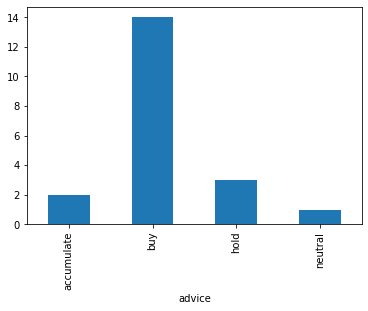

In [76]:
recommendation_df.groupby("advice").count()["title"].plot(kind="bar")
recommendation_df.groupby("date").count()["title"].plot(kind="bar")

<AxesSubplot:>

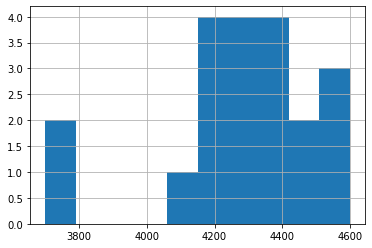

In [75]:
recommendation_df['target'].hist()

In [78]:
!pip install investpy

     |████████████████████████████████| 4.4 MB 2.7 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 235 kB 40.3 MB/s            
  Using cached numpy-1.22.2-cp38-cp38-macosx_10_14_x86_64.whl (17.6 MB)
  Created wheel for investpy: filename=investpy-1.0.8-py3-none-any.whl size=4481576 sha256=140657f68a9cdce6aaa4ba1bd1ba5e3008216de1d09630b75aafa39b8a793a18
  Stored in directory: /Users/vivek/Library/Caches/pip/wheels/9a/6f/8e/21466569113166e5859029b97fcae2b81af57063ed9faf698e
Successfully built investpy
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.1 requires numpy~=1.19.2, but you have numpy 1.22.2 which is incompatible.
tensorflow 2.5.1 requires si

In [83]:
import investpy

In [84]:
df = investpy.get_stock_historical_data(stock='AAPL',
                                        country='United States',
                                        from_date='01/01/2010',
                                        to_date='01/01/2020')
print(df.head())

            Open  High   Low  Close     Volume Currency
Date                                                   
2010-01-04  7.62  7.66  7.58   7.64  493728704      USD
2010-01-05  7.66  7.70  7.62   7.66  601904640      USD
2010-01-06  7.66  7.69  7.53   7.53  552158912      USD
2010-01-07  7.56  7.57  7.47   7.52  477129760      USD
2010-01-08  7.51  7.57  7.47   7.57  447876768      USD


In [90]:
investpy.get_stocks_overview(country='United States')

,country,name,symbol,last,high,low,change,change_percentage,turnover,currency
0,united states,Boeing,BA,209.03,214.73,208.60,-4.55,-2.13%,6970000,USD
1,united states,General Motors,GM,48.60,49.21,47.92,-0.22,-0.45%,16620000,USD
2,united states,Chevron,CVX,133.42,133.91,132.05,-0.19,-0.14%,10690000,USD
3,united states,Citigroup,C,64.14,64.97,63.70,-0.57,-0.88%,18110000,USD
4,united states,Bank of America,BAC,45.96,46.53,45.72,-0.11,-0.24%,37860000,USD
...,...,...,...,...,...,...,...,...,...,...
95,united states,Ciena Corp,CIEN,68.70,69.47,68.08,-0.33,-0.48%,1180000,USD
96,united states,IAC/InterActiveCorp,IAC,109.55,114.62,108.42,-5.46,-4.75%,1030000,USD
97,united states,Intuit,INTU,481.20,498.67,478.75,-14.98,-3.02%,2320000,USD
98,united states,Expedia,EXPE,209.17,211.25,204.72,-0.14,-0.07%,2210000,USD


In [8]:
import requests
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd

%matplotlib inline

In [9]:
response = requests.get(f'https://www.tickertape.in/stocks/tata-consultancy-services-TCS/news?checklist=basic&type=mixed',
            headers={"Accept-Language":"en-US"})
soup = BeautifulSoup(response.content, "html.parser")

In [10]:
soup

<!DOCTYPE html>
<html lang="en-US"><head><meta content="IE=edge" http-equiv="X-UA-Compatible"/><link href="/favicon/favicon.png" rel="shortcut icon"/><link href="/favicon/favicon-192x192.png" rel="apple-touch-icon"/><link href="/manifest/manifest.json" rel="manifest"/><style type="text/css">:root {--white: #ffffff; --font_primary: #535B62; --font_dark: #2f363f; --font_light: #81878c; --font_blue: #0088ea; --font_lighter: #a2a8ae; --brand_primary: #151e28; --brand_success: #28c39a; --brand_danger: #d93741; --brand_warn: #fbe283; --brand_bg: #f9f9f9; --brand_border: #d1d5d8; --brand_hover: #f7f7f7; --brand_gray: #acacac; --brand_light_gray: #e1e1e1; --purple_dark: #5311e9; --purple_light: #7656ff; --premium_dark: #624bff; --item_hover_bg: #373f48; --toast_error: #e8d075; --toast_error_bg: #fffae6; --toast_info: #a7c9de; --toast_info_bg: #effbff; --font_family_regular: 'graphik-regular', Helvetica, Arial, sans-serif; --font_family_medium: 'graphik-medium', Helvetica, Arial, sans-serif; --

In [24]:
data = soup.find_all('p', {'class': 'shave-root'})

In [26]:
data[0].text

'TCS, Kashmir Uni join hands to launch skilling programmes'

In [17]:
data[0]['title']

KeyError: 'title'

In [4]:
from pprint import pprint
import finvizfinance 
import finvizfinance.screener 
from finvizfinance.quote import finvizfinance
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/vivek/nltk_data...


In [7]:
# input ticker sample want to obtain news for
ticker = 'AAPL'

In [8]:
# obtain news per ticker
stock = finvizfinance(ticker)
news = stock.ticker_news()
news

,Date,Title,Link
0,2022-02-24 19:08:00,"User Tracking, The Bell Tolls for Thee",https://finance.yahoo.com/news/user-tracking-b...
1,2022-02-24 18:08:00,Here are the Bay Area cities where software en...,https://www.bizjournals.com/sanjose/news/2022/...
2,2022-02-24 16:41:00,Why megacap stocks rallied after Russia invade...,https://finance.yahoo.com/news/why-megacap-sto...
3,2022-02-24 16:35:00,NYC Marathon Returns to Full Capacity; H.K. Cu...,https://finance.yahoo.com/news/hong-kong-covid...
4,2022-02-24 16:25:00,Stocks Fought Off Huge Losses After Russia Att...,https://www.barrons.com/articles/stock-market-...
...,...,...,...
95,2022-02-18 11:47:00,3 Stocks That Could Be Worth More Than Apple b...,https://www.fool.com/investing/2022/02/18/3-st...
96,2022-02-18 11:23:00,Frances Haugen explains why Apple is more resp...,https://finance.yahoo.com/video/frances-haugen...
97,2022-02-18 10:59:00,Russia-Ukraine Tension Continues; Meta Down 40...,https://www.investopedia.com/ukraine-border-te...
98,2022-02-18 10:26:00,EPAM Systems' (EPAM) Q4 Earnings and Revenue B...,https://finance.yahoo.com/news/epam-systems-ep...


In [17]:
news['Source'] = news['Link']

In [22]:
news['Source'] = news['Source'].apply(lambda x: x.split("//")[1].split("/")[0])

In [23]:
news['Source']

0        finance.yahoo.com
1      www.bizjournals.com
2        finance.yahoo.com
3        finance.yahoo.com
4          www.barrons.com
              ...         
95            www.fool.com
96       finance.yahoo.com
97    www.investopedia.com
98       finance.yahoo.com
99       finance.yahoo.com
Name: Source, Length: 100, dtype: object

In [24]:
news.

,Date,Title,Link,Source
0,2022-02-24 19:08:00,"User Tracking, The Bell Tolls for Thee",https://finance.yahoo.com/news/user-tracking-b...,finance.yahoo.com
1,2022-02-24 18:08:00,Here are the Bay Area cities where software en...,https://www.bizjournals.com/sanjose/news/2022/...,www.bizjournals.com
2,2022-02-24 16:41:00,Why megacap stocks rallied after Russia invade...,https://finance.yahoo.com/news/why-megacap-sto...,finance.yahoo.com
3,2022-02-24 16:35:00,NYC Marathon Returns to Full Capacity; H.K. Cu...,https://finance.yahoo.com/news/hong-kong-covid...,finance.yahoo.com
4,2022-02-24 16:25:00,Stocks Fought Off Huge Losses After Russia Att...,https://www.barrons.com/articles/stock-market-...,www.barrons.com
...,...,...,...,...
95,2022-02-18 11:47:00,3 Stocks That Could Be Worth More Than Apple b...,https://www.fool.com/investing/2022/02/18/3-st...,www.fool.com
96,2022-02-18 11:23:00,Frances Haugen explains why Apple is more resp...,https://finance.yahoo.com/video/frances-haugen...,finance.yahoo.com
97,2022-02-18 10:59:00,Russia-Ukraine Tension Continues; Meta Down 40...,https://www.investopedia.com/ukraine-border-te...,www.investopedia.com
98,2022-02-18 10:26:00,EPAM Systems' (EPAM) Q4 Earnings and Revenue B...,https://finance.yahoo.com/news/epam-systems-ep...,finance.yahoo.com


In [2]:
ticker = yfinance.Ticker("INFY.NS")


In [3]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
data = pdr.get_data_yahoo("TCS.BO", start="2017-01-01", end="2017-04-30")

[*********************100%***********************]  1 of 1 completed


In [7]:
data.drop(columns=['Adj Close'],inplace=True)
data

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-02,1182.500000,1187.500000,1176.449951,1179.525024,50260
2017-01-03,1180.500000,1185.675049,1172.025024,1184.250000,98492
2017-01-04,1184.550049,1193.000000,1179.250000,1189.275024,51342
2017-01-05,1189.275024,1193.500000,1162.500000,1167.275024,117118
2017-01-06,1160.000000,1164.900024,1128.500000,1141.800049,528968
...,...,...,...,...,...
2017-04-24,1150.000000,1168.525024,1141.949951,1164.550049,109302
2017-04-25,1165.500000,1171.650024,1151.500000,1155.650024,86084
2017-04-26,1165.125000,1170.500000,1152.000000,1155.224976,307916


In [5]:
import pandas as pd
import pandas_ta as ta

df = pd.DataFrame() # Empty DataFrame

# Load data
#df = pd.read_csv("path/to/symbol.csv", sep=",")
# OR if you have yfinance installed
df = df.ta.ticker("aapl")

df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [6]:
# Calculate Returns and append to the df DataFrame
df.ta.log_return(cumulative=True, append=True)
df.ta.percent_return(cumulative=True, append=True)

# New Columns with results
df.columns

# Take a peek
df.tail()

# vv Continue Post Processing vv

,Open,High,Low,Close,Volume,Dividends,Stock Splits,CUMLOGRET_1,CUMPCTRET_1
Date,,,,,,,,,
2022-02-18,169.820007,170.539993,166.190002,167.300003,82614200,0.0,0.0,7.419123,1666.570309
2022-02-22,164.979996,166.690002,162.149994,164.320007,91162800,0.0,0.0,7.401150,1636.867067
2022-02-23,165.539993,166.149994,159.750000,160.070007,90009200,0.0,0.0,7.374946,1594.505001
2022-02-24,152.580002,162.850006,152.000000,162.740005,141147500,0.0,0.0,7.391488,1621.118328
2022-02-25,163.839996,165.119995,160.869995,164.850006,91881700,0.0,0.0,7.404370,1642.149854


In [7]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,CUMLOGRET_1,CUMPCTRET_1
Date,,,,,,,,,
1980-12-12,0.100326,0.100762,0.100326,0.100326,469033600,0.0,0.0,0.000000,0.000000
1980-12-15,0.095528,0.095528,0.095092,0.095092,175884800,0.0,0.0,-0.053581,-0.052170
1980-12-16,0.088548,0.088548,0.088112,0.088112,105728000,0.0,0.0,-0.129812,-0.121739
1980-12-17,0.090293,0.090729,0.090293,0.090293,86441600,0.0,0.0,-0.105362,-0.100001
1980-12-18,0.092911,0.093347,0.092911,0.092911,73449600,0.0,0.0,-0.076782,-0.073908
...,...,...,...,...,...,...,...,...,...
2022-02-18,169.820007,170.539993,166.190002,167.300003,82614200,0.0,0.0,7.419123,1666.570309
2022-02-22,164.979996,166.690002,162.149994,164.320007,91162800,0.0,0.0,7.401150,1636.867067
2022-02-23,165.539993,166.149994,159.750000,160.070007,90009200,0.0,0.0,7.374946,1594.505001


In [8]:
df = df.ta.cdl_pattern(name="all")

[X] Please install TA-Lib to use 2crows. (pip install TA-Lib)
[X] Please install TA-Lib to use 3blackcrows. (pip install TA-Lib)
[X] Please install TA-Lib to use 3inside. (pip install TA-Lib)
[X] Please install TA-Lib to use 3linestrike. (pip install TA-Lib)
[X] Please install TA-Lib to use 3outside. (pip install TA-Lib)
[X] Please install TA-Lib to use 3starsinsouth. (pip install TA-Lib)
[X] Please install TA-Lib to use 3whitesoldiers. (pip install TA-Lib)
[X] Please install TA-Lib to use abandonedbaby. (pip install TA-Lib)
[X] Please install TA-Lib to use advanceblock. (pip install TA-Lib)
[X] Please install TA-Lib to use belthold. (pip install TA-Lib)
[X] Please install TA-Lib to use breakaway. (pip install TA-Lib)
[X] Please install TA-Lib to use closingmarubozu. (pip install TA-Lib)
[X] Please install TA-Lib to use concealbabyswall. (pip install TA-Lib)
[X] Please install TA-Lib to use counterattack. (pip install TA-Lib)
[X] Please install TA-Lib to use darkcloudcover. (pip instal

In [1]:
import re
from bs4 import BeautifulSoup as soup
from urllib.request import Request, urlopen

In [18]:
ticker = "AAPL"
url = ("http://finviz.com/quote.ashx?t=" +ticker.lower())
req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req).read()
html = soup(webpage, "html.parser")


In [70]:
recommendation = {"data":[]}
for f in html.find_all('td', {'class': 'fullview-ratings-inner'}):
    for tr in f.find_all('table'):
        for td in tr.find_all('td'):
            recommendation["data"].append(td.text)

In [79]:
list_recommendation = []
for i in range(0,len(recommendation['data']),5):
    list_recommendation.append(recommendation['data'][i:i+5])

In [93]:
symbol = "AAPL"
recommendation_dict = {
    'ticker': [],
    'date': [],
    'title': [],
    'text': [],
    'source': [],
    'url': [],
    'advice': [],
    'target': [],
    'analyst': []
}


for value in list_recommendation:
    recommendation_dict['ticker'].append(symbol)
    recommendation_dict['date'].append(value[0])
    recommendation_dict['title'].append(value[1])
    recommendation_dict['source'].append("FinViz")
    recommendation_dict['url'].append(f"https://finviz.com/quote.ashx?t={symbol}")
    recommendation_dict['analyst'].append(value[2])
    recommendation_dict['advice'].append(value[3])
    recommendation_dict['text'].append(value[3])
    recommendation_dict['target'].append(value[4])

['Jan-28-22', 'Upgrade', 'New Street', 'Sell → Neutral', '$165']


In [94]:
recommendation_dict

{'ticker': ['AAPL'],
 'date': ['Jan-28-22'],
 'title': ['Upgrade'],
 'text': ['Sell → Neutral'],
 'source': ['FinViz'],
 'url': ['https://finviz.com/quote.ashx?t=AAPL'],
 'advice': ['Sell → Neutral'],
 'target': ['$165'],
 'analyst': ['New Street'],
 'sentiment': [],
 'clean_text': []}